In [45]:
import pickle
import random
import numpy as np
import math
import matplotlib.pyplot as plt

# 截断问题分析

## 工作路径

In [46]:
ROBUST_BASE = '/home/LAB/wangd/graduation_project/ranked list truncation/dataset/robust04'
MQ_BASE = '/home/LAB/wangd/graduation_project/ranked list truncation/dataset/mq2007'
DATASET_BASE = ROBUST_BASE

## 所用指标是否关于k构成可优化的问题

In [20]:
# 导入ground truth
with open('{}/gt.pkl'.format(DATASET_BASE), 'rb') as f:
    gt = pickle.load(f)
    for key in gt: gt[key] = set(gt[key])

def cal_F1(ranked_list: list, k: int) -> float:
    """
    计算F1 score
    k: 截断到第k个，从1计数
    """
    count, N_D = sum(ranked_list[:k]), sum(ranked_list)
    p_k = count / k
    r_k = (count / N_D) if N_D != 0 else 0
    return (2 * p_k * r_k / (p_k + r_k)) if p_k + r_k != 0 else 0

def cal_DCG(ranked_list: list, k: int, penalty=-1) -> float:
    """
    计算DCG
    """
    value = 0
    for i in range(k): 
        value += (1 / math.log(i + 2, 2)) if ranked_list[i] else (penalty / math.log(i + 2, 2))
    return value

def dataset_prepare(dataset_name: str) -> list:
    # 这里不需要train
    with open('{}/{}_train.pkl'.format(DATASET_BASE, dataset_name), 'rb') as f:
        train_data = pickle.load(f)
    train_rl = {}
    for key in train_data: 
        train_rl[key] = list(map(lambda x: 1 if x in gt[key] else 0, train_data[key].keys()))
    return train_rl

def greedy_scores(dataset_name: str) -> float:
    train_set = dataset_prepare(dataset_name)
    F1_k, DCG_k = [], []
    for key in train_set:
        per_k_F1, per_k_DCG = [0], [0]
        for i in range(1, 41):
            per_k_F1.append(cal_F1(train_set[key], i))
            per_k_DCG.append(cal_DCG(train_set[key], i))
        F1_k.append(per_k_F1)
        DCG_k.append(per_k_DCG)
    
    F1_k_mean, DCG_k_mean = np.mean(np.array(F1_k), axis=0), np.mean(np.array(DCG_k), axis=0)
    return F1_k_mean, DCG_k_mean

In [21]:
f1_bm25, dcg_bm25 = greedy_scores('bm25')
f1_drmm_tks, dcg_drmm_tks = greedy_scores('drmm_tks')

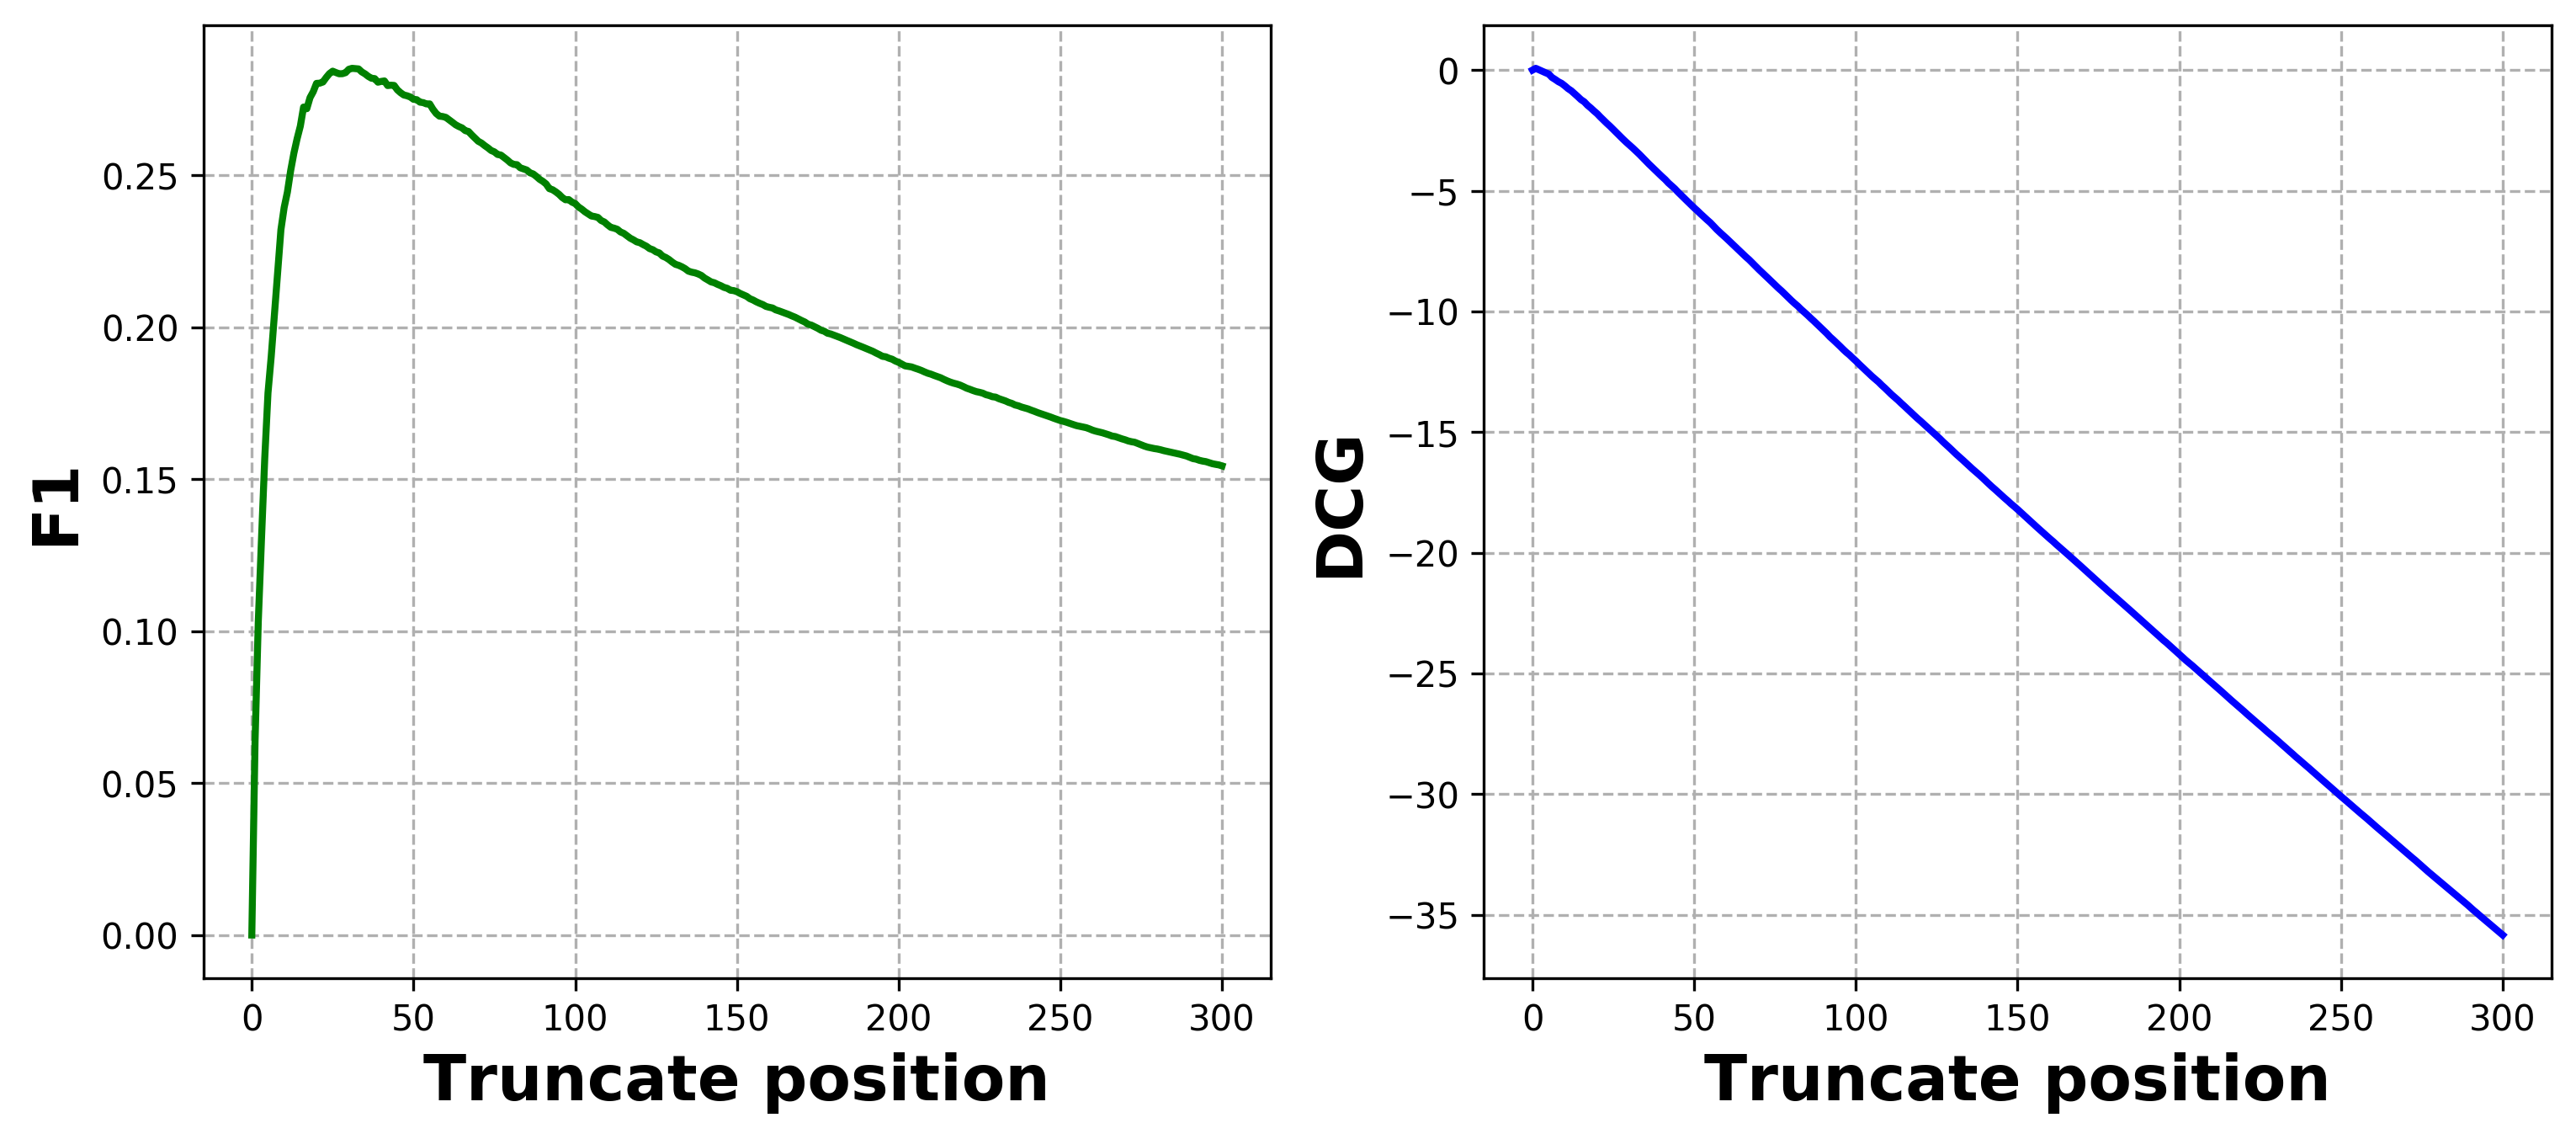

In [16]:
x = np.arange(301)

plt.figure(figsize=(12,5), dpi=300)
plt.subplot(1, 2, 1)
plt.grid(linestyle = "--")
plt.plot(x, f1_bm25, color="green",linewidth=2.)
plt.xlabel('Truncate position', fontsize=18,fontweight='bold')
plt.ylabel('F1', fontsize=18,fontweight='bold')

plt.subplot(1, 2, 2)
plt.grid(linestyle = "--")
plt.plot(x, dcg_bm25, color="blue",linewidth=2.)
plt.xlabel('Truncate position', fontsize=18,fontweight='bold')
plt.ylabel('DCG', fontsize=18,fontweight='bold')

plt.show()

Text(0, 0.5, 'DCG')

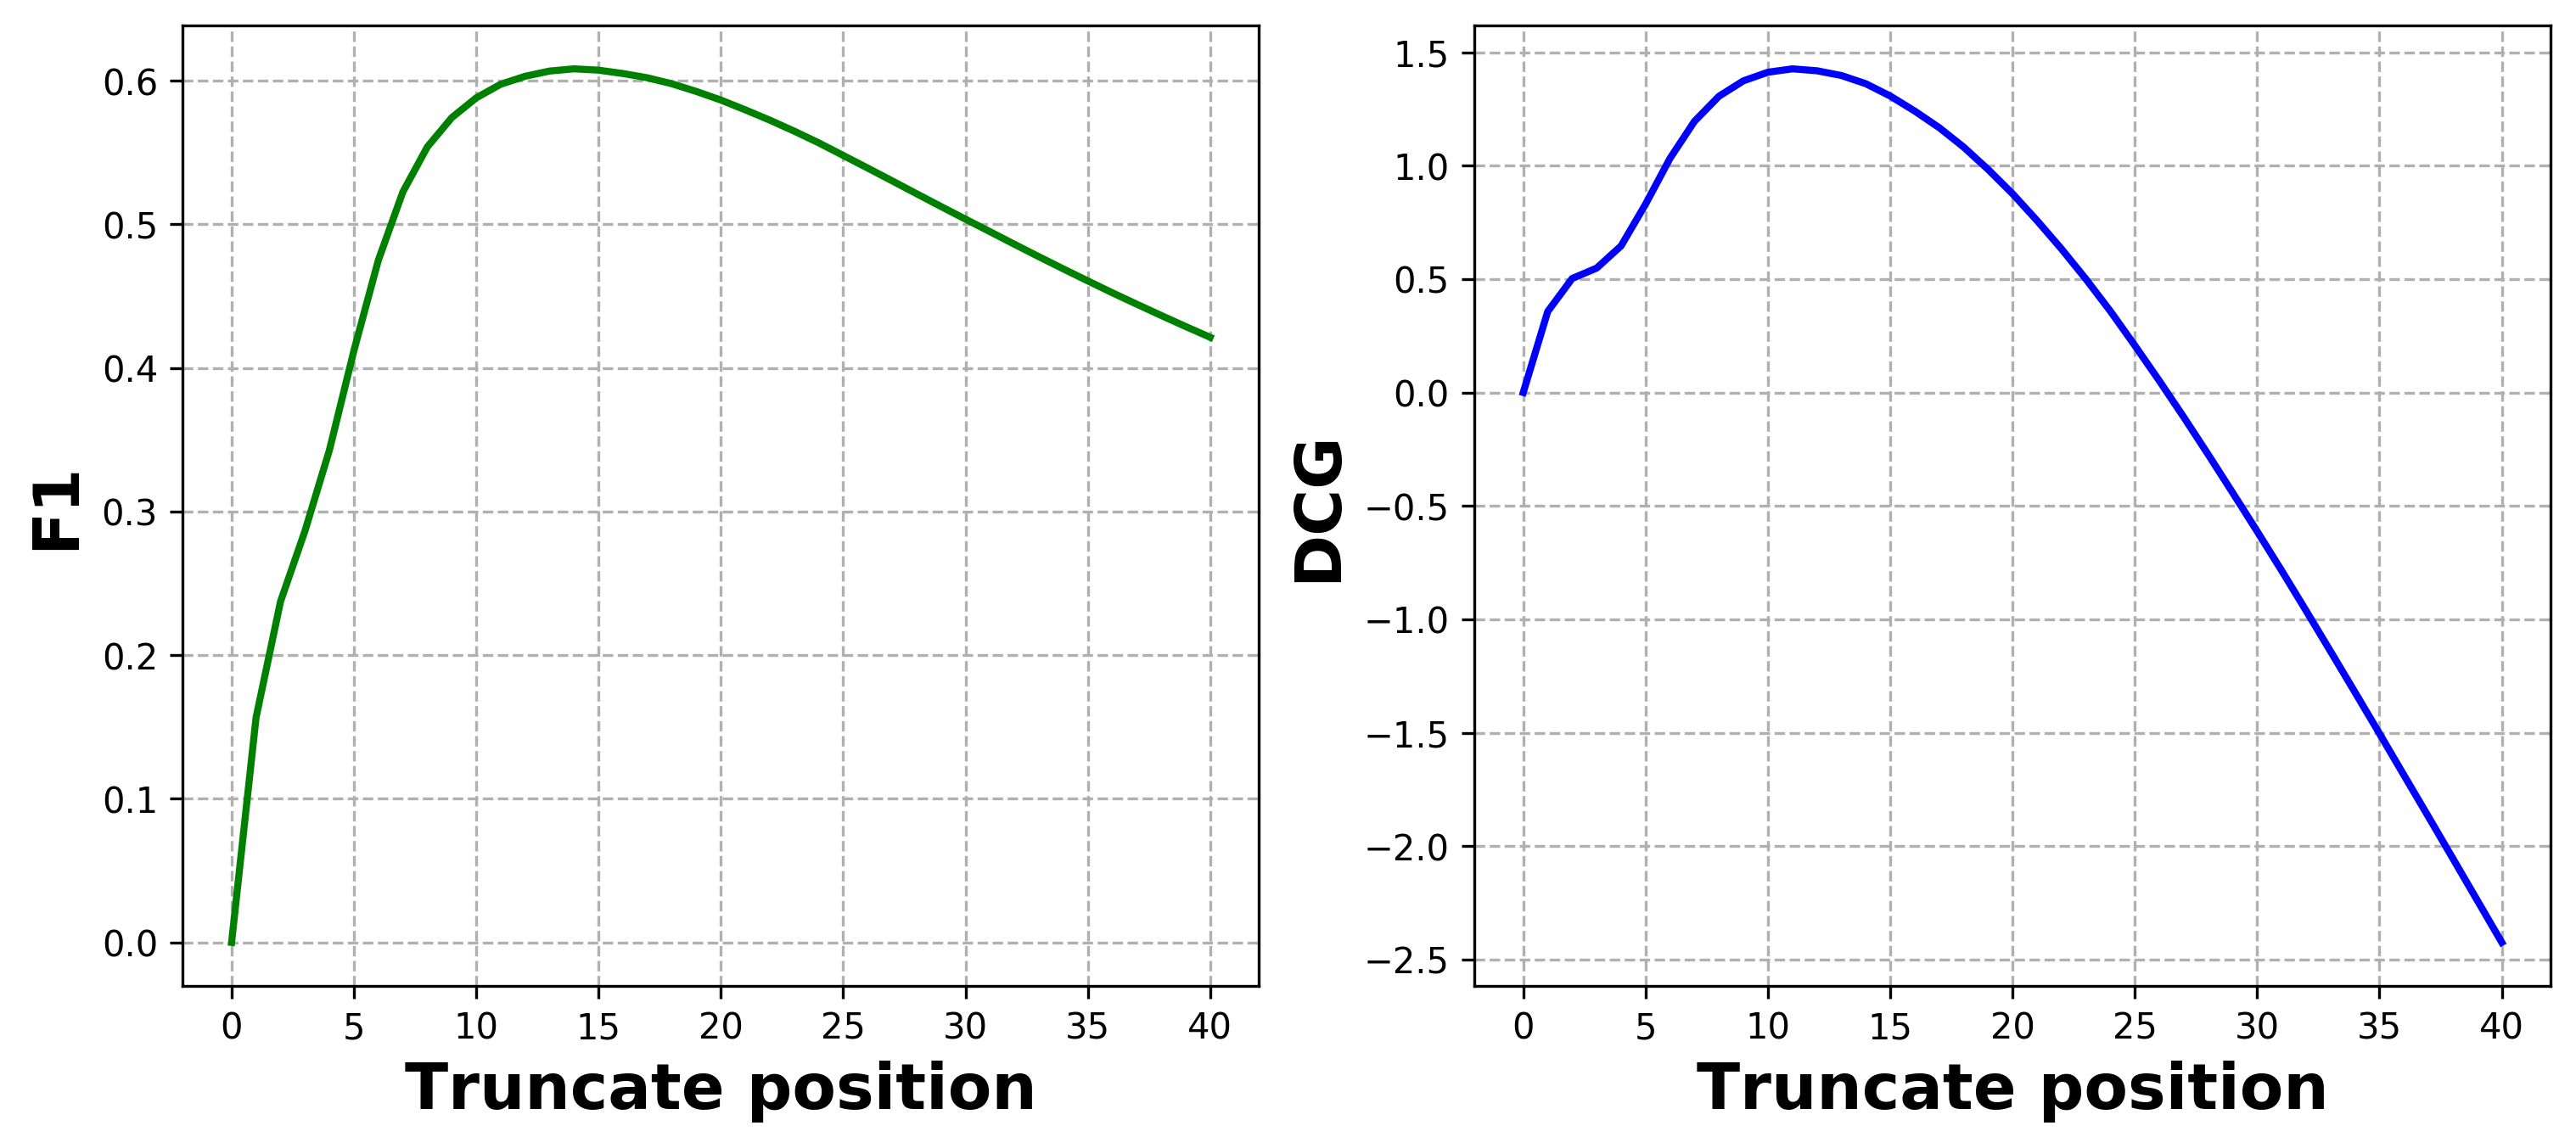

In [22]:
x = np.arange(41)
plt.figure(figsize=(12,5), dpi=300)
plt.subplot(1, 2, 1)
plt.grid(linestyle = "--")
plt.plot(x, f1_drmm_tks, color="green",linewidth=2.)
plt.xlabel('Truncate position', fontsize=18,fontweight='bold')
plt.ylabel('F1', fontsize=18,fontweight='bold')

plt.subplot(1, 2, 2)
plt.grid(linestyle = "--")
plt.plot(x, dcg_drmm_tks, color="blue",linewidth=2.)
plt.xlabel('Truncate position', fontsize=18,fontweight='bold')
plt.ylabel('DCG', fontsize=18,fontweight='bold')

* 在bm25和drmm上，使用dcg指标的时候，需要控制惩罚项，否则会因为惩罚项太大，导致模型过分小心，甚至产生从0截断的情况，使得截断毫无意义；

* 在我们使用的所有数据集上，f1指标均可作为优化指标；

## 检索偏差分析

In [72]:
dataset_name = 'drmm_tks'
with open('{}/{}_train.pkl'.format(DATASET_BASE, dataset_name), 'rb') as f:
    train_data = pickle.load(f)
with open('{}/{}_test.pkl'.format(DATASET_BASE, dataset_name), 'rb') as f:
    test_data = pickle.load(f)
with open('{}/gt.pkl'.format(DATASET_BASE), 'rb') as f:
    gt = pickle.load(f)
    for key in gt: gt[key] = set(gt[key])

In [73]:
train_rl, test_rl = {}, {}
for key in train_data: 
    train_rl[key] = list(map(lambda x: 1 if x in gt[key] else 0, train_data[key].keys()))
for key in test_data:
    test_rl[key] = list(map(lambda x: 1 if x in gt[key] else 0, test_data[key].keys()))

In [74]:
all_data = train_rl.copy()
all_data.update(test_rl)
len(all_data)

243

In [75]:
from tqdm import tqdm
def countp(all_data):
    p = []
    for i in tqdm(range(1, 301)):
        total_irr = 0
        for qid in all_data:
            ir_num = i - sum(all_data[qid][:i])
            total_irr += ir_num
#         p.append(total_irr / (len(all_data) * i))
        p.append(total_irr / (len(all_data)))
    return p

In [76]:
count = 0
for qid in all_data: 
    count += sum(all_data[qid])
print(count / len(all_data))

65.93827160493827


In [77]:
p = countp(all_data)
len(p)

100%|██████████| 300/300 [00:00<00:00, 1592.54it/s]


300

Text(0, 0.5, 'Proportion')

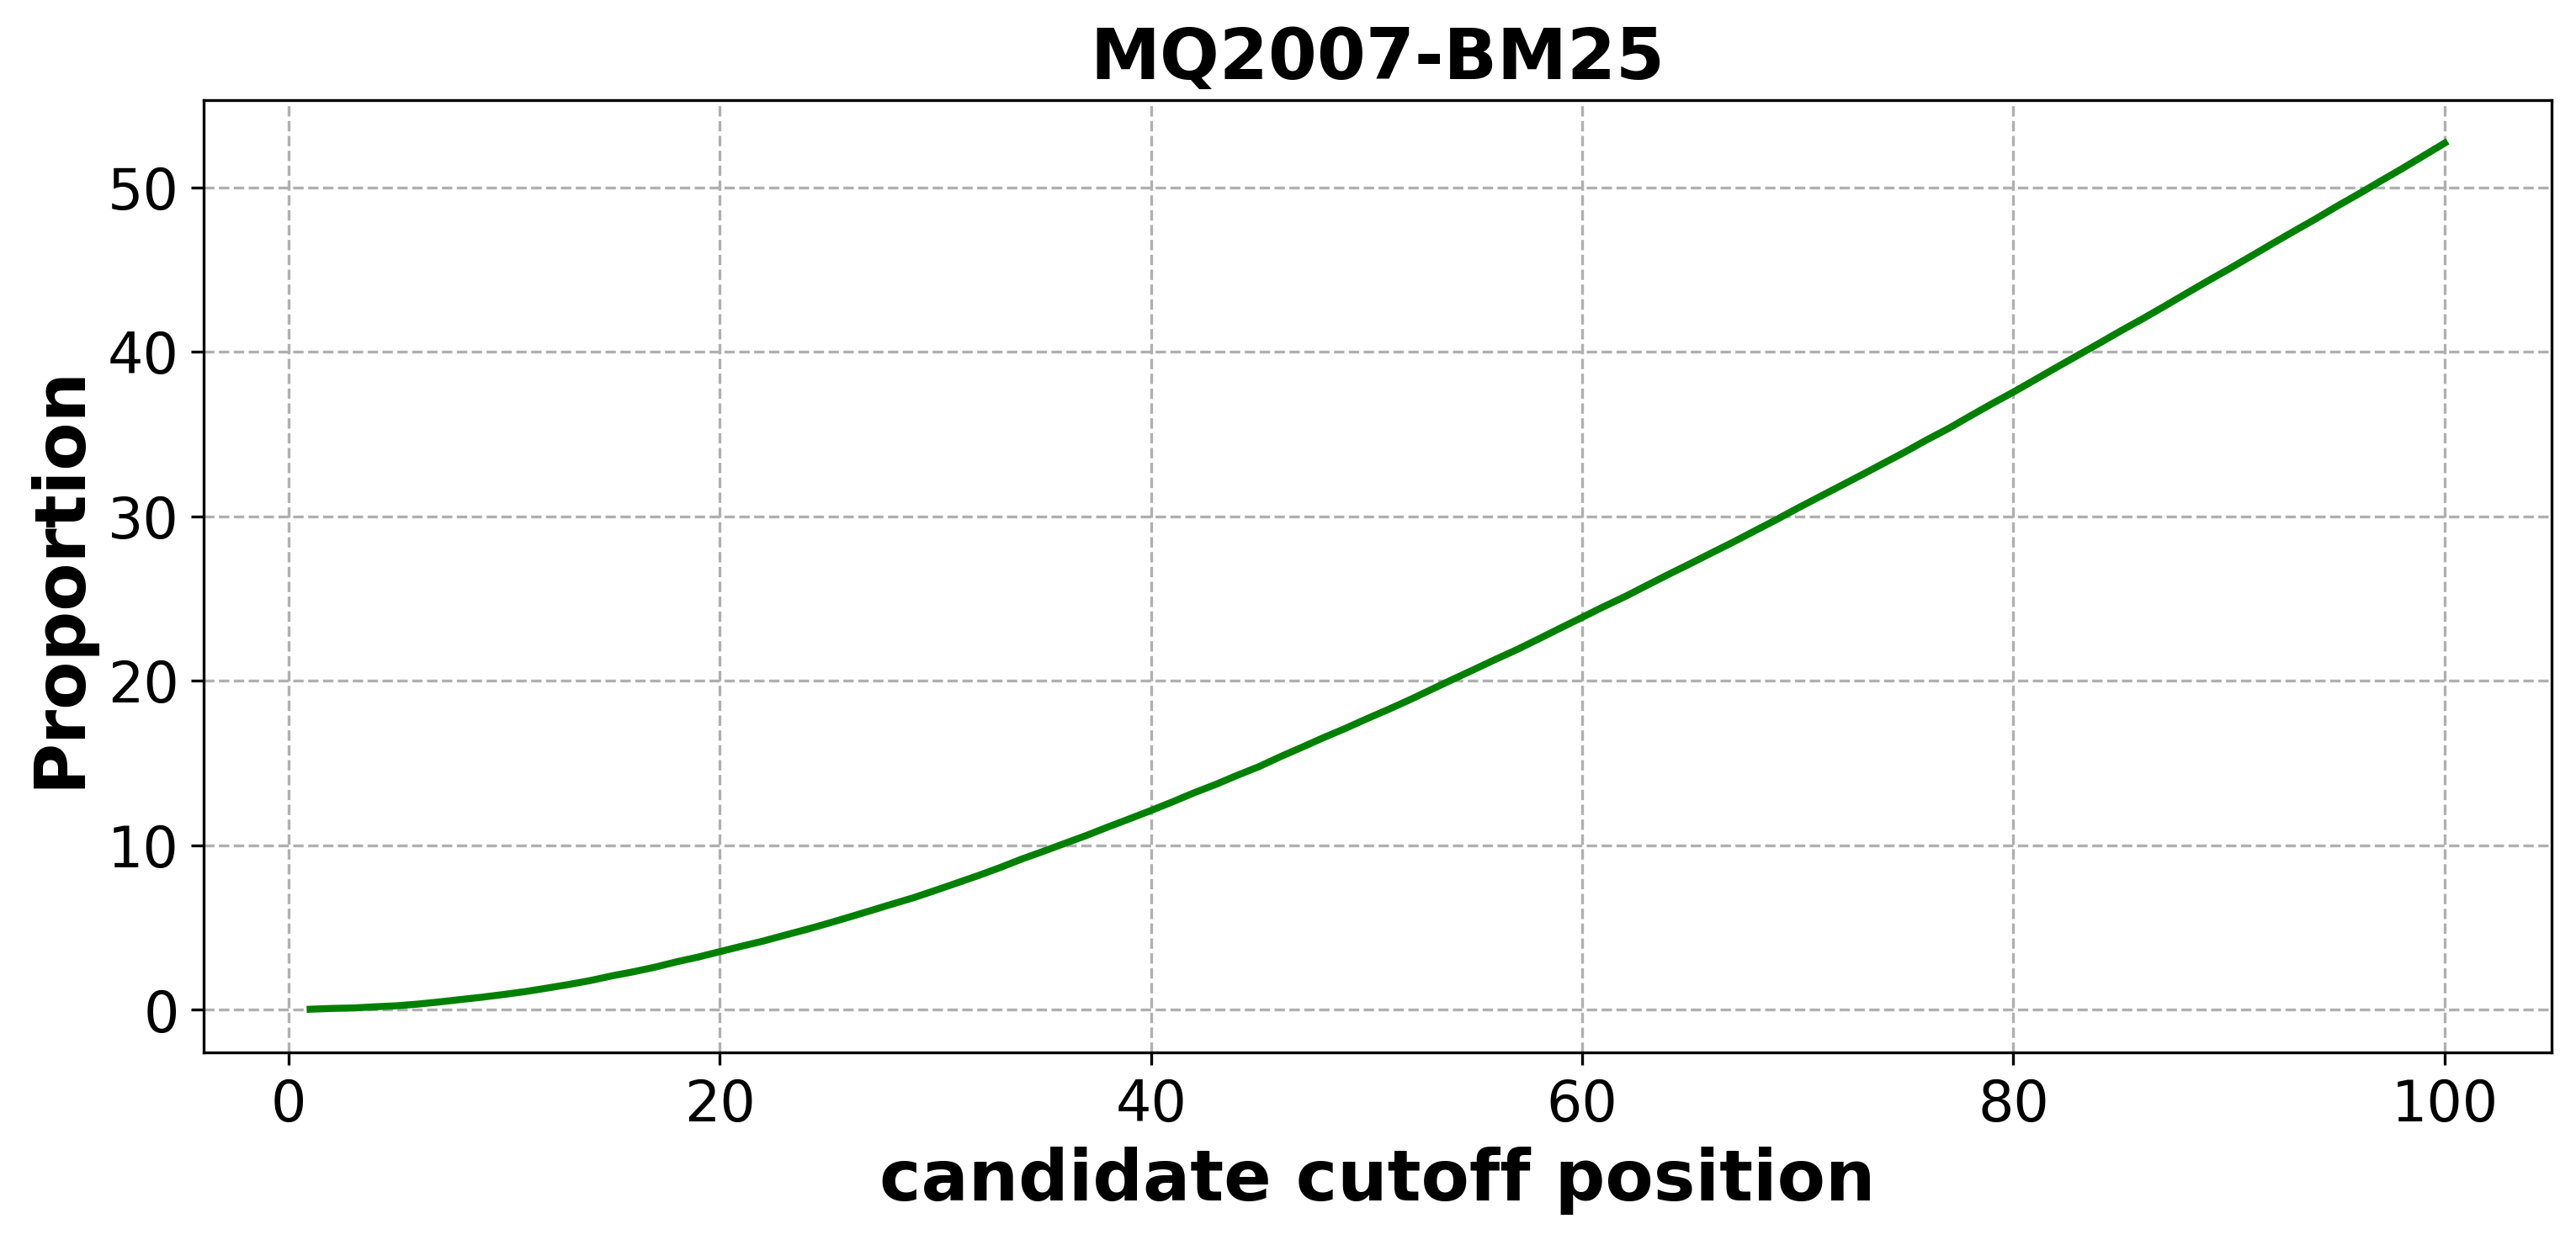

In [79]:
from matplotlib.ticker import FuncFormatter

x = list(range(1, 101))
plt.figure(figsize=(12,5), dpi=300)
plt.grid(linestyle = "--")
plt.plot(x,p[:100], color="green",linewidth=2.)
plt.title('MQ2007-BM25', fontsize=20,fontweight='bold')
plt.tick_params(labelsize=16)
plt.xlabel('candidate cutoff position', fontsize=20,fontweight='bold')
plt.ylabel('Proportion', fontsize=20,fontweight='bold')


# def to_percent(temp, position):
#     return '%1.0f'%(100*temp) + '%'
# plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

In [2]:
direct_ch = [0.9494241302610122, 0.9485454425701889, 0.9488516381389394, 0.9494171545312307, 0.9493420890832468, 0.9484337579923897, 0.9482836207476819, 0.9492097182299887, 0.9482656656946281, 0.9493226345562962, 0.9494933984515193, 0.9493803562860471, 0.9488242510519646, 0.9493046466065301, 0.9494821869716954, 0.9489965219490791, 0.9499112395185012, 0.9492978639802866, 0.9493860643165023, 0.9492942222598539, 0.9492568051438937, 0.9486286082790827, 0.9490981404890103, 0.9488067633780564, 0.9490495073503954, 0.9494300273173024, 0.9486644276835511, 0.9494621380877053, 0.9484687706633281, 0.9493070258784613, 0.9480986948776984, 0.9494340843043094, 0.9497307512268284, 0.9488206448533184, 0.949050058016508, 0.9492739860787924, 0.9482937007245645, 0.9493600988852965, 0.948995283978418, 0.9493602229394329, 0.9489077041056211, 0.9491321627092031, 0.9492519252935411, 0.9487582197612635, 0.9496489461011013, 0.9478798274539055, 0.9495430136536578, 0.9495316293929605, 0.949199254536787, 0.9490820368548356, 0.94886626912783, 0.9488094225556232, 0.9489963829557835, 0.9490940541411591, 0.9481640153359164, 0.949266470565419, 0.9489815495016533, 0.9489612198506906, 0.9493277795144424, 0.949517564206508, 0.9486737028493522, 0.9481561574854493, 0.9491112002890019, 0.9490561390543919, 0.9495650789544193, 0.949143786124111, 0.9482063744548258, 0.9497420284527432, 0.9495014896767439, 0.9483437948665475, 0.9495327630575652, 0.9494830148616089, 0.9489960898254685, 0.9492371418579054, 0.949201743320333, 0.9488905621283973, 0.9493077575737132, 0.9495557511520525, 0.9494937744785885, 0.9493419117408616, 0.9489393886045517, 0.9495164524164454, 0.9484285125883367, 0.9486246014525994, 0.9483179366148254, 0.949061358188407, 0.9492773069289457, 0.9489162871183812, 0.9492761569454788, 0.9495287805964171, 0.9484580031550071, 0.9486544977159467, 0.9493029593023719, 0.9496903998890703, 0.948669802601667, 0.9492151899582307, 0.9498495112938619, 0.948743188536632, 0.9490451840553881, 0.9493404176716111, 0.9491774548519493, 0.9493808354461397, 0.9495715597359252, 0.9494236876774668, 0.9490469305679273, 0.9497060188004662, 0.9494067702138755, 0.9487219109751452, 0.9495911960335768, 0.9495484189275464, 0.9489124551041803, 0.9490396939664644, 0.948657944869202, 0.9487813891514371, 0.9495174345835021, 0.949298389855745, 0.9489431717338432, 0.9495977813586485, 0.9494499002379351, 0.9481541310247448, 0.9478898660796997, 0.948680727768299, 0.9485527696930378, 0.9493548119926742, 0.9494695536520303, 0.9492841220674343, 0.9482830193795373, 0.9489806564683116, 0.9493994623703029, 0.9483123580188492, 0.9496194388206319, 0.9491612365489208, 0.9484170009218247, 0.9486331691783502, 0.9491261698534779, 0.9490808654937426, 0.9494949338678211, 0.9494715694247905, 0.948845430261524, 0.9491528792665418, 0.9491425623398071, 0.9492498770459432, 0.9489948217229761, 0.9496188431275863, 0.9489251047935567, 0.9495158335839522, 0.9487482363776291, 0.9485505059423801, 0.9485616326707509, 0.9491255175806319, 0.9488818281435893, 0.9482495901427372, 0.9482921132120851, 0.9489251940527529, 0.9484632976429044, 0.9493561461172236, 0.948607121194399, 0.9485429484774739, 0.9491745941132033, 0.949245489974427, 0.9479376769557447, 0.9493886956753312, 0.9496591394008649, 0.949150736276728, 0.9491368317892013, 0.9492243101343689, 0.9497801083311603, 0.9479947512968971, 0.9492078831147115, 0.9488080836948116, 0.9491113603275025, 0.9483639103434026, 0.9492876308804862, 0.9494418494928878, 0.949335843094906, 0.9491286099524258, 0.9492744379433858, 0.9495389368164338, 0.9479112189752478, 0.9485918810382443, 0.9497064442662456, 0.9492309394457316, 0.9490953940766296, 0.9496036058646562, 0.9485819916683088, 0.948967803933933, 0.9485747426298742, 0.9491243061557263, 0.9491806008176399, 0.9490603544766849, 0.9497949449105583, 0.9498007568626019, 0.9489008717996041, 0.9482378378529759, 0.9493931916225533, 0.9491390530547272, 0.9493718677651246, 0.9492319754014245, 0.9487231845357547, 0.9494812703495608]
pre_train_ch = [0.31280378502020156, 0.31597678043009764, 0.3222249178942488, 0.3305365366195711, 0.33637948358583214, 0.3426167232667895, 0.3494186386023036, 0.3530732705376516, 0.359931692619706, 0.36678987346114533, 0.3743862796948325, 0.3802082993348205, 0.3869596043742024, 0.38904328997035775, 0.39769705093167407, 0.4047879078619757, 0.41250229886695655, 0.41833748648138513, 0.42631623528550494, 0.42787774127968825, 0.4364499074814539, 0.44488679440524426, 0.4522168776509057, 0.45224976736475986, 0.4666933829505463, 0.4744300910033804, 0.4732291223470596, 0.48012613678052085, 0.48667787408175256, 0.49634142284311994, 0.49665460581208787, 0.5021347875669837, 0.5094670067457787, 0.5191173351426354, 0.523705859508728, 0.5268871248727749, 0.5343919036160999, 0.5395903531094561, 0.5438710603430282, 0.5479550898179668, 0.5551189538127591, 0.559665925433951, 0.5676082608521537, 0.567121818735862, 0.5741853530790456, 0.5798012074225815, 0.5828388215550817, 0.5926080703556648, 0.5914305747413844, 0.598719428286881, 0.6055418892492874, 0.6099134219623277, 0.612219160420236, 0.6146863948666871, 0.6173844229546582, 0.6257158066146079, 0.6300792157912121, 0.6327399477125782, 0.6394170724753085, 0.6393739340702027, 0.6448907998016616, 0.6513223135023897, 0.6527815768440247, 0.6538384747319482, 0.6584787119042228, 0.661167829580565, 0.6637751972446623, 0.6657479958157345, 0.6702074701080545, 0.674659552179021, 0.6781956243313545, 0.6794889041324319, 0.6848067871101782, 0.6880616732540242, 0.691029352838649, 0.6958316147290338, 0.6960673221219669, 0.6970744348913246, 0.696220923966408, 0.7038681567566901, 0.7059865003097439, 0.7058359245315542, 0.7116244565244144, 0.7104100627201834, 0.7148928976651825, 0.7208867728049051, 0.7198331047898614, 0.720730353410153, 0.7235811567037431, 0.7269238498985443, 0.7275470738793824, 0.733689737917781, 0.7317052645447795, 0.7335878918258845, 0.7365967624756972, 0.7376973371215547, 0.738036685500032, 0.7445862296998668, 0.7424890468466477, 0.7445266256329155, 0.7481354056946128, 0.7465077420700779, 0.7466866028022356, 0.7494783495333609, 0.7535737844106819, 0.7547611706055916, 0.7544649994101374, 0.7554742934075961, 0.7579563037272204, 0.7572614283458263, 0.7587529671899873, 0.7610995934154128, 0.7609968640721209, 0.7616635321571341, 0.7653152236607738, 0.7642713973895003, 0.7695296935930187, 0.7632602393911936, 0.7666656547596367, 0.7657762501254953, 0.7672074833714195, 0.7724004903370911, 0.7720134559477385, 0.7733324818056035, 0.7735228105654335, 0.7756553890960622, 0.7773048748363889, 0.7772564253283198, 0.7756436346223277, 0.7788097284627928, 0.7791705494933306, 0.7810847707128385, 0.7833363905562084, 0.78598288776542, 0.7834753789000822, 0.7856845067633966, 0.7840104450491941, 0.7842204123124926, 0.7875426203494802, 0.7852801353707968, 0.7878603464150365, 0.7906289425367815, 0.7878835869814247, 0.7895467363694918, 0.7898578885191384, 0.7934891426733981, 0.7888590496036055, 0.7939873740662591, 0.7917576216759327, 0.7931104601936189, 0.7940990195185447, 0.7974545178848639, 0.7965084295980545, 0.794964575959762, 0.7993794691710512, 0.798301431960797, 0.7973272142214366, 0.7984790214896071, 0.8003553378479434, 0.7982977933241919, 0.7991786479784653, 0.8000994350556379, 0.8030443135928129, 0.8031274606087623, 0.8042032859424635, 0.8010303875184454, 0.8059492956564049, 0.8048816651935461, 0.8052635588148407, 0.8045632944275931, 0.8036415502371341, 0.8061231311997041, 0.8080776056324319, 0.8071619667217135, 0.8075039064542464, 0.8080176727915547, 0.810759719276643, 0.8081421156948755, 0.8097735095360209, 0.8092918363982271, 0.8117854765159572, 0.8109721957003717, 0.8114631518232066, 0.8144234328039015, 0.8102383359845321, 0.8140265447743895, 0.814189026875414, 0.8132871602403666, 0.8148525234555104, 0.8131363170205279, 0.8160827099331847, 0.8148222835899206, 0.8134851679922829, 0.8162357282722124, 0.8131744616908119, 0.8185849778059524, 0.8157036737032696, 0.8171585347788147, 0.8164010942938307, 0.8179593092064049]
direct_at = [0.9495261167066691, 0.9495310627350312, 0.9491001817531941, 0.9496187486926285, 0.9499310120015027, 0.9484928012182292, 0.9489474852240625, 0.9490724187319163, 0.9496596238314451, 0.9498309543463233, 0.9497826474697104, 0.9496837427772927, 0.948927224925135, 0.9495828135568802, 0.949504048637087, 0.9499971934187321, 0.9498817262718869, 0.9489295895493204, 0.94954990192724, 0.9493754997148949, 0.9489401089960255, 0.94925113968308, 0.9487975224712646, 0.9494528520338019, 0.9483929279095609, 0.9482664513232247, 0.9492204656869434, 0.9489456713968145, 0.9491638111592315, 0.9490370255146454, 0.9492725374671526, 0.9493776271796186, 0.9498090080720912, 0.9486447298400309, 0.9494596630090623, 0.949277490771891, 0.9493325599245994, 0.9476168757218859, 0.9492936089668829, 0.9493024844377272, 0.9491837040605475, 0.9499034545609634, 0.9489986986016536, 0.9489150418611378, 0.949888390638104, 0.9495076454382554, 0.9497635326085435, 0.94949855106053, 0.9488920331314201, 0.9496369923695864, 0.949250740757744, 0.9491256584191875, 0.9493722662739505, 0.9493620224458225, 0.949223486006531, 0.948586588382953, 0.9493205335890481, 0.9495906688242879, 0.9487362196268692, 0.9490832792212851, 0.9495869208414213, 0.9491195719957659, 0.9499459478121963, 0.949422472784553, 0.9497561393933646, 0.9497072602132356, 0.948895780104254, 0.9494034156188154, 0.9498219674020719, 0.9491916258366457, 0.9493463353817446, 0.9488904408448823, 0.949523855467749, 0.9494382398387099, 0.9493841196973241, 0.9490850085426592, 0.9497763121486541, 0.9493939917810232, 0.9495101789369563, 0.9494057870852398, 0.9494237680295174, 0.9495163177636512, 0.9487261591655234, 0.9498952125566037, 0.9495983881341621, 0.9494507910272392, 0.949203116497592, 0.949268960635331, 0.9493587644439326, 0.9496873813105754, 0.9493723048657252, 0.9498426395468904, 0.9490417375860762, 0.9498448254949607, 0.9500038548403431, 0.9491019677179804, 0.9499678271600114, 0.9493582917524792, 0.9493195905991879, 0.9493186784145055, 0.9495537384665713, 0.9495493694099194, 0.950141180525654, 0.9498082048353718, 0.9496608317467707, 0.9495514138538172, 0.9487591183006219, 0.9487972848520047, 0.9495936253277621, 0.9496691868283131, 0.9494134153924894, 0.9497885594362103, 0.9499332219271432, 0.9497432172745096, 0.9495637647451568, 0.9495841258733423, 0.94953531732899, 0.9491825604579474, 0.9493865486608085, 0.949366273330336, 0.9494794246442334, 0.9498580955609082, 0.9497718025483703, 0.9496267216137125, 0.9498547516367772, 0.949513624176354, 0.9490915326838378, 0.9484109720572056, 0.9497568425063717, 0.9496421920934328, 0.9498264839598842, 0.9481028012956397, 0.9495596974072779, 0.9497280476662933, 0.949479486061367, 0.9495281759438388, 0.9493992772662349, 0.9493554828782932, 0.9486412817650498, 0.9498741852398872, 0.9496244586454768, 0.9495816519037765, 0.9496095434709838, 0.948937335581865, 0.9489184236141115, 0.949740782693359, 0.9498603765131284, 0.9490364462881304, 0.9489126903233875, 0.9496368055999019, 0.949420443398403, 0.949222641109874, 0.9492080651943935, 0.949962212981661, 0.949385955880655, 0.9480359183813378, 0.9497676181376187, 0.9496684692519055, 0.9493917935807966, 0.9487844170423582, 0.9491298664130536, 0.9493394176514058, 0.9493849787782226, 0.9492221644650511, 0.9497562867723369, 0.949708319869534, 0.9492299508702912, 0.9497619033089233, 0.9496588799757791, 0.9496229947798269, 0.9496250265077004, 0.9494539579308571, 0.9494366833631631, 0.9496763581388235, 0.9490487611617228, 0.949374893436868, 0.9496298848847647, 0.9494469430751934, 0.949564771724075, 0.9497368317130401, 0.9497122501228411, 0.9496219842735363, 0.9492034816337434, 0.9490086198974025, 0.9496345021214184, 0.949646000655013, 0.9497571945780902, 0.9494899293321595, 0.9492827019517905, 0.9495472384499022, 0.9499221540418686, 0.9495461459570997, 0.9496837486782717, 0.9493057430876402, 0.9498167238222333, 0.9497393724279318, 0.9497794543235992, 0.9496210909369067, 0.9498639360602981, 0.949847424173283]
pre_train_at = [0.16305633520650187, 0.18684064770738237, 0.2227616325758644, 0.25777993122289705, 0.2997458224047862, 0.3578388333560742, 0.4134286921336714, 0.47184944246647625, 0.54037999415352, 0.5955559097753491, 0.6545545878956708, 0.7060383702426122, 0.7567066854820779, 0.797236052196564, 0.8241044574270872, 0.8459951254767004, 0.8652188664242855, 0.8816140998233859, 0.8935938757112905, 0.9031725030682202, 0.9068472823326607, 0.9136851282288898, 0.919585750192852, 0.9254966416171495, 0.9266756602174882, 0.9306862917460623, 0.93353769602847, 0.9344228064458884, 0.9369053599959043, 0.9370533746970764, 0.9385322354276786, 0.9387586839476041, 0.9403093244312922, 0.940651670094837, 0.942606322166802, 0.9417678065869654, 0.9438234433663135, 0.9455839061452267, 0.9430632301727749, 0.9435668926978359, 0.9447626593390416, 0.9439465517564226, 0.9470258207313409, 0.9452322729609509, 0.9461174347914879, 0.9464847234934359, 0.9453694750875883, 0.9470182093837567, 0.9464496551262302, 0.9470233737497923, 0.9460473618278133, 0.9461292823441714, 0.9464530086105334, 0.9472597861011944, 0.9480408469794644, 0.9471501561877804, 0.9463351574798733, 0.946683084679635, 0.9473162371741284, 0.9473525344660135, 0.9470910675908696, 0.9479979701116846, 0.9482177118164046, 0.9481777926355306, 0.9472001484627885, 0.9475933516558255, 0.9470689680755553, 0.9486694020259462, 0.9476758975155833, 0.9458781091683109, 0.9476590325956803, 0.947384652503545, 0.9475129567620522, 0.9475674414538295, 0.9480333497793053, 0.9483521147740941, 0.9476679822022278, 0.9471725471942225, 0.9480733948346891, 0.948242572777119, 0.9487625958191588, 0.9474265483057511, 0.9473962171223155, 0.9476522707794606, 0.9493957839881592, 0.9479702675840646, 0.9479599053884995, 0.9471983675086113, 0.947755585569673, 0.9492072812811061, 0.9479083649503425, 0.9485017401746931, 0.9476541776561241, 0.9482654473637935, 0.9480993630458154, 0.9486423453237354, 0.9485776917265347, 0.9480101844228545, 0.9490338099821537, 0.9486222183095212, 0.9482484501637917, 0.9484628936516855, 0.9483874258375286, 0.9473265695169214, 0.9481482639259535, 0.9481771387863176, 0.9487518518022263, 0.9486384601395583, 0.9486650689135839, 0.9494126991244792, 0.9483837520612525, 0.9473132915994442, 0.9474204105973936, 0.9468992518170932, 0.948793111440785, 0.9486090442625461, 0.9483004357099409, 0.9486511995149769, 0.9487777597064551, 0.9489102686508624, 0.9487647027247353, 0.9482403164864189, 0.947702208595317, 0.9486309046235902, 0.9486349909867338, 0.9478480083035723, 0.9475687414973895, 0.948251800034589, 0.9489603828564694, 0.9479831543007575, 0.94887128858207, 0.9482766279284354, 0.9486479224313994, 0.9482078639186758, 0.9492258389283588, 0.9486364627340149, 0.9487720414420184, 0.949001441356382, 0.9487485818108435, 0.9483000568762563, 0.9484397602214086, 0.9488400653838951, 0.9484685373365588, 0.9489201541243226, 0.948131308059309, 0.9491357557332847, 0.9487755307681972, 0.9488636483663259, 0.9481624687761592, 0.9488398218688271, 0.9491210179154053, 0.9485077658851019, 0.9481295137942786, 0.9487908060756345, 0.9486183532104329, 0.9489520205500673, 0.9481196083196457, 0.9484165385127389, 0.9488006644337569, 0.9494036633951473, 0.9488157799833059, 0.9490908939495452, 0.9491840514144044, 0.9487055535965206, 0.9489364807182585, 0.948441101712765, 0.948472215498907, 0.9483603533102103, 0.949346552176778, 0.9485809270331842, 0.9488366899954375, 0.9483930155932059, 0.9482368292004187, 0.9490913787738018, 0.9490228282184437, 0.94896761180424, 0.9482745489384332, 0.9480628049322665, 0.9486002244117596, 0.9491067151065128, 0.948225785185145, 0.9490753806546228, 0.9485379497323315, 0.9485541529957496, 0.948629972159511, 0.9489368054809637, 0.9479252081529819, 0.9481697663075517, 0.9491573167323504, 0.9491147310584542, 0.9482189608739382, 0.9487176265479398, 0.9485494483962418, 0.9491326073651496, 0.9479660362747897, 0.9490201331972719, 0.9487768555825232, 0.948416531806806, 0.948967746435836, 0.9490318197686778]

In [3]:
pre_train_at[15]

0.8459951254767004

Text(0, 0.5, 'AUC')

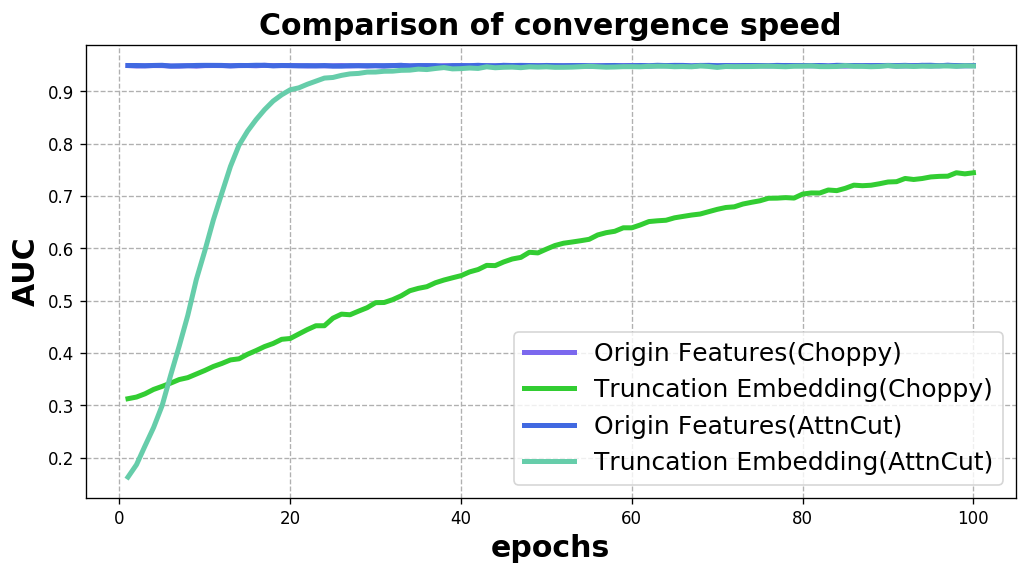

In [8]:
from matplotlib.ticker import FuncFormatter

x = list(range(1, 101))
plt.figure(figsize=(10,5), dpi=120)
plt.grid(linestyle = "--")

plt.plot(x,direct_ch[:100], color="mediumslateblue",linewidth=3.,label='Origin Features(Choppy)')
plt.plot(x,pre_train_ch[:100], color="limegreen",linewidth=3.,label='Truncation Embedding(Choppy)')
plt.plot(x,direct_at[:100], color="royalblue",linewidth=3.,label='Origin Features(AttnCut)')
plt.plot(x,pre_train_at[:100], color="mediumaquamarine",linewidth=3.,label='Truncation Embedding(AttnCut)')
plt.legend(fontsize=15)

plt.title('Comparison of convergence speed', fontsize=18,fontweight='bold')
plt.xlabel('epochs', fontsize=18,fontweight='bold')
plt.ylabel('AUC', fontsize=18,fontweight='bold')

In [10]:
direct_ch_r = [-30.870448345037858, -30.81806066910329, -24.46726712822538, -20.118880402342604, -20.51845201415539, -20.21271069982517, -20.193748780370203, -20.06935751076032, -20.458391017684626, -20.292897825549325, -20.14330466100505, -20.27709399152523, -20.531079195426486, -20.52983772981505, -20.5295888613191, -20.23396886037019, -20.259620350387607, -20.100687896551957, -20.288060910500157, -19.946974549932527, -19.945129314009442, -20.249989831808534, -20.05861068531078, -20.411469384136502, -20.26073399759935, -20.312670322623436, -20.46153097764715, -20.336062109767745, -19.94824479271825, -20.285002446351402, -20.149286926835288, -20.157661038087372, -20.373068218885827, -20.32432235689994, -20.130183400844345, -19.973172652481775, -19.991955803655294, -20.04234050181027, -20.094289694576922, -19.971995721121132, -19.981563285182215, -20.356313912577708, -20.271852064356594, -20.405962858384562, -20.1032108178077, -20.21090176691253, -20.30053041870968, -20.367366996025908, -20.222579621415385, -20.11328262300615, -20.152983548812042, -19.84351847158067, -20.4956610013063, -20.269926183126078, -20.040539303105476, -20.40139540291785, -20.49315877368657, -19.862247671450667, -20.170980407010525, -20.296635372043973, -20.104608473855638, -20.36894648629037, -20.130029581426168, -19.858907350853123, -20.369721431729573, -20.238454299427477, -20.14137802931385, -20.24597111414595, -20.131216773991582, -20.36748196777844, -20.056422537196116, -20.228535098656145, -20.420585557977297, -20.153792708659175, -20.376767839542403, -20.333619945922308, -20.335038050144643, -20.32506414135883, -19.99390048336282, -20.30001123660374, -20.095114332348217, -20.030782383113014, -20.220077732008683, -20.163692530470477, -20.13472302214396, -20.152642337187327, -19.975372424314713, -20.0759155738893, -20.0890502337804, -20.046094274780927, -20.20393700683255, -20.004858084879, -20.299671256550656, -20.04315938284557, -20.123991313984597, -20.13987661293946, -20.30103247645062, -20.060046175222567, -20.067520627459007, -20.108359604006008]
pre_train_ch_r = [-29.394114026498848, -29.14718931704892, -29.139387436227643, -28.905719653392843, -29.31560765171745, -29.265559627194808, -28.999069239300702, -28.822477728542065, -29.16327424741565, -29.154900373339693, -28.944491633221457, -28.86695201953366, -28.61385366641617, -28.672677906825747, -28.75843333889467, -28.55251802842563, -28.650599470809635, -28.412810633297703, -28.2324619239399, -28.265619384900777, -28.24807864908575, -28.064375417488964, -27.768185528131717, -27.79226027092391, -27.6664871382002, -27.966735844358727, -27.77300435311392, -27.63428781761515, -27.426982273121062, -27.46687729931059, -27.46900143553455, -27.221864729078796, -27.521941337315262, -27.302336871654717, -27.15131017831653, -26.61234804011164, -27.055248557674908, -27.095608976537694, -26.926011555763644, -26.791364890446186, -26.932350058970314, -26.749535592473034, -26.76776579554953, -26.723469000424842, -26.789689670688496, -26.490562784864288, -26.608822978145724, -26.357118043696637, -26.38888897140967, -26.353225967526036, -26.130378968477487, -26.238631664514706, -26.219273043035116, -26.230999630764284, -26.006405186347592, -25.840488484041252, -26.152315056706176, -25.741482750017433, -25.410787358486573, -25.539622174749812, -25.74817943839458, -25.79422440449336, -25.24113205077551, -25.5953895921141, -25.770189993562923, -25.739676609031743, -25.23053918450832, -25.327101676125313, -25.379595758451824, -25.473774516041004, -25.390080533721026, -25.43235027734153, -25.179748150946246, -25.255628281645183, -25.56384628033975, -25.39790419088236, -25.260185166504098, -25.33554282641189, -25.187519162634235, -25.420594161069744, -25.466761880506233, -25.25846896028343, -25.187883669408475, -25.230201574270623, -25.250780888815992, -25.510574128133403, -25.2521004069628, -25.389014487923653, -25.40183231397345, -25.38287232804167, -25.117111268118943, -24.88740769340237, -25.107502201777578, -25.099904549017328, -25.316541525373648, -25.272793307601667, -25.158006704253545, -24.703398253409674, -25.27503834329431, -25.00106524100469]
direct_at_r = [-20.151931160974854, -20.40709326584713, -20.31897942619639, -20.003705659037852, -20.187461248691783, -20.114883966665502, -20.253643886305632, -20.276151089532988, -20.372161743929837, -20.205395512875363, -19.88811806562716, -20.051792413671766, -20.264680546315425, -20.205589766570608, -20.147872966342142, -20.321795909822903, -20.098774002915906, -20.22448723837467, -20.31705037560383, -20.292576309724137, -20.428538850768827, -19.96069471396637, -20.089620228308064, -20.178257081430587, -20.082954512828568, -20.39975315625149, -20.25064630381408, -20.158495122759348, -20.304839434770706, -20.51127212953, -20.18048845681317, -20.43980351756263, -20.115684268291155, -20.193349499277623, -20.164027965257027, -20.191471389185335, -20.219320124427863, -19.965962558841365, -20.09995366313529, -20.060615799632227, -20.158375420955583, -20.345868930065738, -19.916717793979025, -20.193926827892625, -20.00289617400123, -20.11513464466772, -20.28222116151492, -20.03463471366306, -20.212997088919515, -20.5070038385234, -20.03182576541418, -20.416489420025762, -19.898211645238366, -20.34188752583114, -20.09658364556732, -20.353285008433062, -19.93699676569786, -20.08499905041561, -20.34797104453572, -20.293857172189288, -20.069415832707616, -20.409772728500258, -20.437874562844566, -20.512177486043676, -20.082704765783134, -20.033166166089167, -20.415989082294267, -20.123687525613068, -20.304232034170333, -20.33203300980354, -20.375672871567012, -20.30089323929736, -20.37797230747494, -20.126353370801137, -20.086174437313538, -20.25693616471853, -20.02430931186499, -20.258911900291437, -20.38443976221744, -20.118499334858967, -20.304868602734267, -20.22434501208455, -20.02519406510781, -20.324009120670976, -19.890918763701297, -20.16397442230378, -20.198702923864037, -20.205895475994108, -20.404345051958725, -20.481058025893866, -20.36881403688478, -19.914856855970562, -20.111810959043957, -20.078320718701313, -20.264549774857826, -20.143850281321196, -19.951666105865474, -20.275024542307484, -20.317687576942284, -20.179358513423757]
pre_train_at_r = [-30.732910915125814, -30.652101936154565, -30.929818721266827, -30.748706201446748, -30.886472928134214, -30.320972827846237, -30.330846247178584, -30.400779145509023, -30.584952641807387, -30.09496121305819, -30.25723619828517, -30.159802270514923, -29.939043684590285, -29.60697425606091, -28.128452882615658, -27.551167695109513, -27.045816220763037, -25.549289237137554, -24.474801394680192, -24.061434322084306, -23.499698050260417, -23.559007396165605, -23.446176505057924, -23.4418440115831, -23.23667774068864, -22.737483008365125, -23.22211421689061, -22.992625909681514, -22.934411996978863, -22.848022389909445, -22.483287590147803, -22.850324503467643, -22.86596147657975, -22.613054303042578, -22.676271435461587, -22.939394817432536, -22.745192373656472, -22.77458211655884, -23.027039599874534, -22.62136283465575, -23.02166835565321, -22.868200074012442, -22.39348109510717, -22.67560199703792, -22.803466893444615, -22.68571870399679, -22.685180690568608, -22.900434726573366, -22.286021912996848, -22.375615564593993, -22.26997551357167, -22.569153384467484, -22.627239074263407, -22.63860315267288, -22.20227623317104, -22.50298117850613, -22.408226407607494, -22.467004152491807, -22.060252439561882, -22.31022878592389, -22.32519305713366, -22.473995682917806, -22.468803743752183, -22.431355263305086, -22.19027192228814, -22.4547774287033, -22.326173492071536, -22.268564399348016, -21.99743500209917, -22.189649205526035, -22.062300343471826, -22.184165092153812, -21.808695571157564, -21.93684439378274, -21.525371487727785, -21.977608560906383, -22.239919719402188, -22.048993247262757, -22.017752558234083, -22.070416291937857, -22.02511140321983, -22.010518867771093, -21.92434415834283, -22.07401612816479, -21.956999363931672, -22.25391604352265, -21.929741205537887, -22.10354150206075, -22.093190598244384, -21.78182556155267, -21.80446176294497, -21.836149113810105, -21.851951654916174, -21.877468363698846, -21.88879757884002, -22.01698877620885, -21.954135780190654, -21.92277088168743, -21.856260504008393, -21.937402323130662]

Text(0, 0.5, 'DCG')

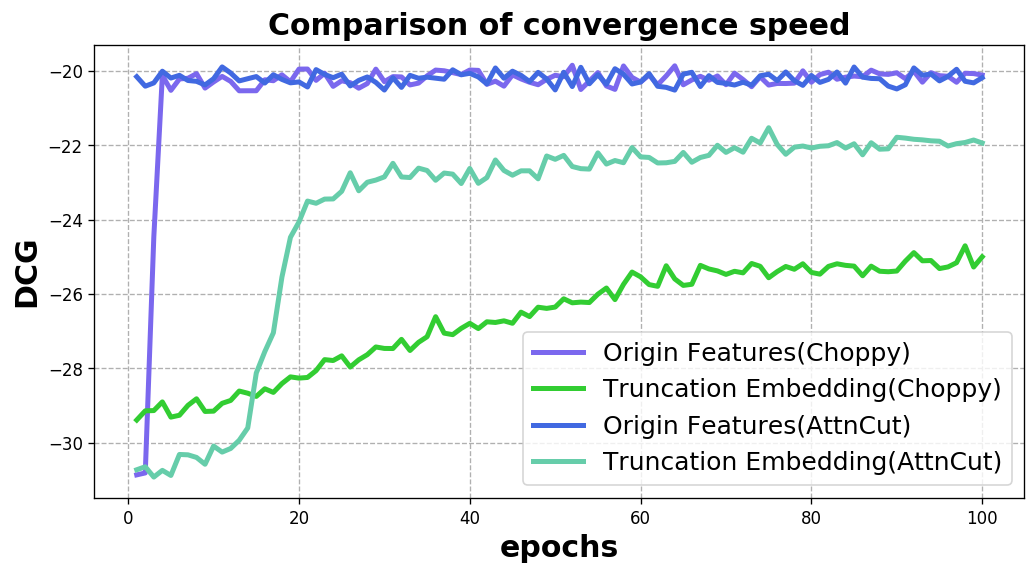

In [11]:
from matplotlib.ticker import FuncFormatter

x = list(range(1, 101))
plt.figure(figsize=(10,5), dpi=120)
plt.grid(linestyle = "--")

plt.plot(x,direct_ch_r[:100], color="mediumslateblue",linewidth=3.,label='Origin Features(Choppy)')
plt.plot(x,pre_train_ch_r[:100], color="limegreen",linewidth=3.,label='Truncation Embedding(Choppy)')
plt.plot(x,direct_at_r[:100], color="royalblue",linewidth=3.,label='Origin Features(AttnCut)')
plt.plot(x,pre_train_at_r[:100], color="mediumaquamarine",linewidth=3.,label='Truncation Embedding(AttnCut)')
plt.legend(fontsize=15)

plt.title('Comparison of convergence speed', fontsize=18,fontweight='bold')
plt.xlabel('epochs', fontsize=18,fontweight='bold')
plt.ylabel('DCG', fontsize=18,fontweight='bold')

In [20]:
pre_train_at_r[15]

-27.551167695109513

In [1]:
import torch as t

In [2]:
a = t.tensor([[1.,2.],[3.,4]])
a

tensor([[1., 2.],
        [3., 4.]])

In [3]:
b = t.sum(a, axis=1).unsqueeze(dim=1)

In [4]:
a.div(b)

tensor([[0.3333, 0.6667],
        [0.4286, 0.5714]])

In [12]:
c = t.min(a, axis=1)[0].unsqueeze(dim=1)

In [15]:
a.sub(c)

tensor([[0., 1.],
        [0., 1.]])

In [14]:
a - c

tensor([[0., 1.],
        [0., 1.]])

In [18]:
b.log()

tensor([[1.0986],
        [1.9459]])

In [25]:
b.add(b).div(2).log()

tensor([[1.0986],
        [1.9459]])

In [26]:
b.mul(2)

tensor([[ 6.],
        [14.]])

In [36]:
a = [0.2222, 0.2000, 0.3636, 0.5000, 0.4615, 0.4286, 0.5333, 0.5000, 0.5882,
        0.6667, 0.7368, 0.7000, 0.6667, 0.6364, 0.6087, 0.5833, 0.5600, 0.5385,
        0.5185, 0.5000, 0.4828, 0.4667, 0.4516, 0.4375, 0.4242, 0.4118, 0.4000,
        0.3889, 0.3784, 0.3684, 0.4103, 0.4000, 0.3902, 0.3810, 0.3721, 0.3636,
        0.3556, 0.3478, 0.3404, 0.3333, 0.3265, 0.3200, 0.3137, 0.3077, 0.3019,
        0.2963, 0.2909, 0.2857, 0.2807, 0.2759, 0.2712, 0.2667, 0.2623, 0.2581,
        0.2540, 0.2500, 0.2462, 0.2424, 0.2388, 0.2353, 0.2319, 0.2286, 0.2254,
        0.2222, 0.2192, 0.2162, 0.2133, 0.2105, 0.2078, 0.2051, 0.2025, 0.2000,
        0.1975, 0.1951, 0.1928, 0.1905, 0.1882, 0.1860, 0.1839, 0.1818, 0.1798,
        0.1778, 0.1758, 0.1739, 0.1720, 0.1702, 0.1684, 0.1667, 0.1649, 0.1633,
        0.1616, 0.1600, 0.1584, 0.1569, 0.1553, 0.1538, 0.1524, 0.1509, 0.1495,
        0.1481, 0.1468, 0.1455, 0.1441, 0.1429, 0.1416, 0.1404, 0.1391, 0.1379,
        0.1368, 0.1356, 0.1345, 0.1333, 0.1322, 0.1311, 0.1301, 0.1290, 0.1280,
        0.1270, 0.1260, 0.1250, 0.1240, 0.1231, 0.1221, 0.1212, 0.1203, 0.1194,
        0.1185, 0.1176, 0.1168, 0.1159, 0.1151, 0.1143, 0.1135, 0.1127, 0.1119,
        0.1111, 0.1103, 0.1096, 0.1088, 0.1081, 0.1074, 0.1067, 0.1060, 0.1053,
        0.1046, 0.1039, 0.1032, 0.1026, 0.1019, 0.1013, 0.1006, 0.1000, 0.0994,
        0.0988, 0.0982, 0.0976, 0.0970, 0.0964, 0.0958, 0.0952, 0.0947, 0.0941,
        0.0936, 0.0930, 0.0925, 0.0920, 0.0914, 0.0909, 0.0904, 0.0899, 0.0894,
        0.0889, 0.0884, 0.0879, 0.0874, 0.0870, 0.0865, 0.0860, 0.0856, 0.0851,
        0.0847, 0.0842, 0.0838, 0.0833, 0.0829, 0.0825, 0.0821, 0.0816, 0.0812,
        0.0808, 0.0804, 0.0800, 0.0796, 0.0792, 0.0788, 0.0784, 0.0780, 0.0777,
        0.0773, 0.0769, 0.0766, 0.0762, 0.0758, 0.0755, 0.0751, 0.0748, 0.0744,
        0.0741, 0.0737, 0.0734, 0.0731, 0.0727, 0.0724, 0.0721, 0.0717, 0.0714,
        0.0711, 0.0708, 0.0705, 0.0702, 0.0699, 0.0696, 0.0693, 0.0690, 0.0687,
        0.0684, 0.0681, 0.0678, 0.0675, 0.0672, 0.0669, 0.0667, 0.0664, 0.0661,
        0.0658, 0.0656, 0.0653, 0.0650, 0.0648, 0.0645, 0.0643, 0.0640, 0.0637,
        0.0635, 0.0632, 0.0630, 0.0627, 0.0625, 0.0623, 0.0620, 0.0618, 0.0615,
        0.0613, 0.0611, 0.0608, 0.0606, 0.0604, 0.0602, 0.0599, 0.0597, 0.0595,
        0.0593, 0.0590, 0.0588, 0.0586, 0.0584, 0.0582, 0.0580, 0.0578, 0.0576,
        0.0573, 0.0571, 0.0569, 0.0567, 0.0565, 0.0563, 0.0561, 0.0559, 0.0557,
        0.0556, 0.0554, 0.0552, 0.0550, 0.0548, 0.0546, 0.0544, 0.0542, 0.0541,
        0.0539, 0.0537, 0.0535, 0.0533, 0.0532, 0.0530, 0.0528, 0.0526, 0.0525,
        0.0523, 0.0521, 0.0519]
len(a)

300

In [37]:
import numpy as np
b = np.exp(a)

In [42]:
c = np.exp(np.array(a)/0.35)

Text(0, 0.5, 'F1')

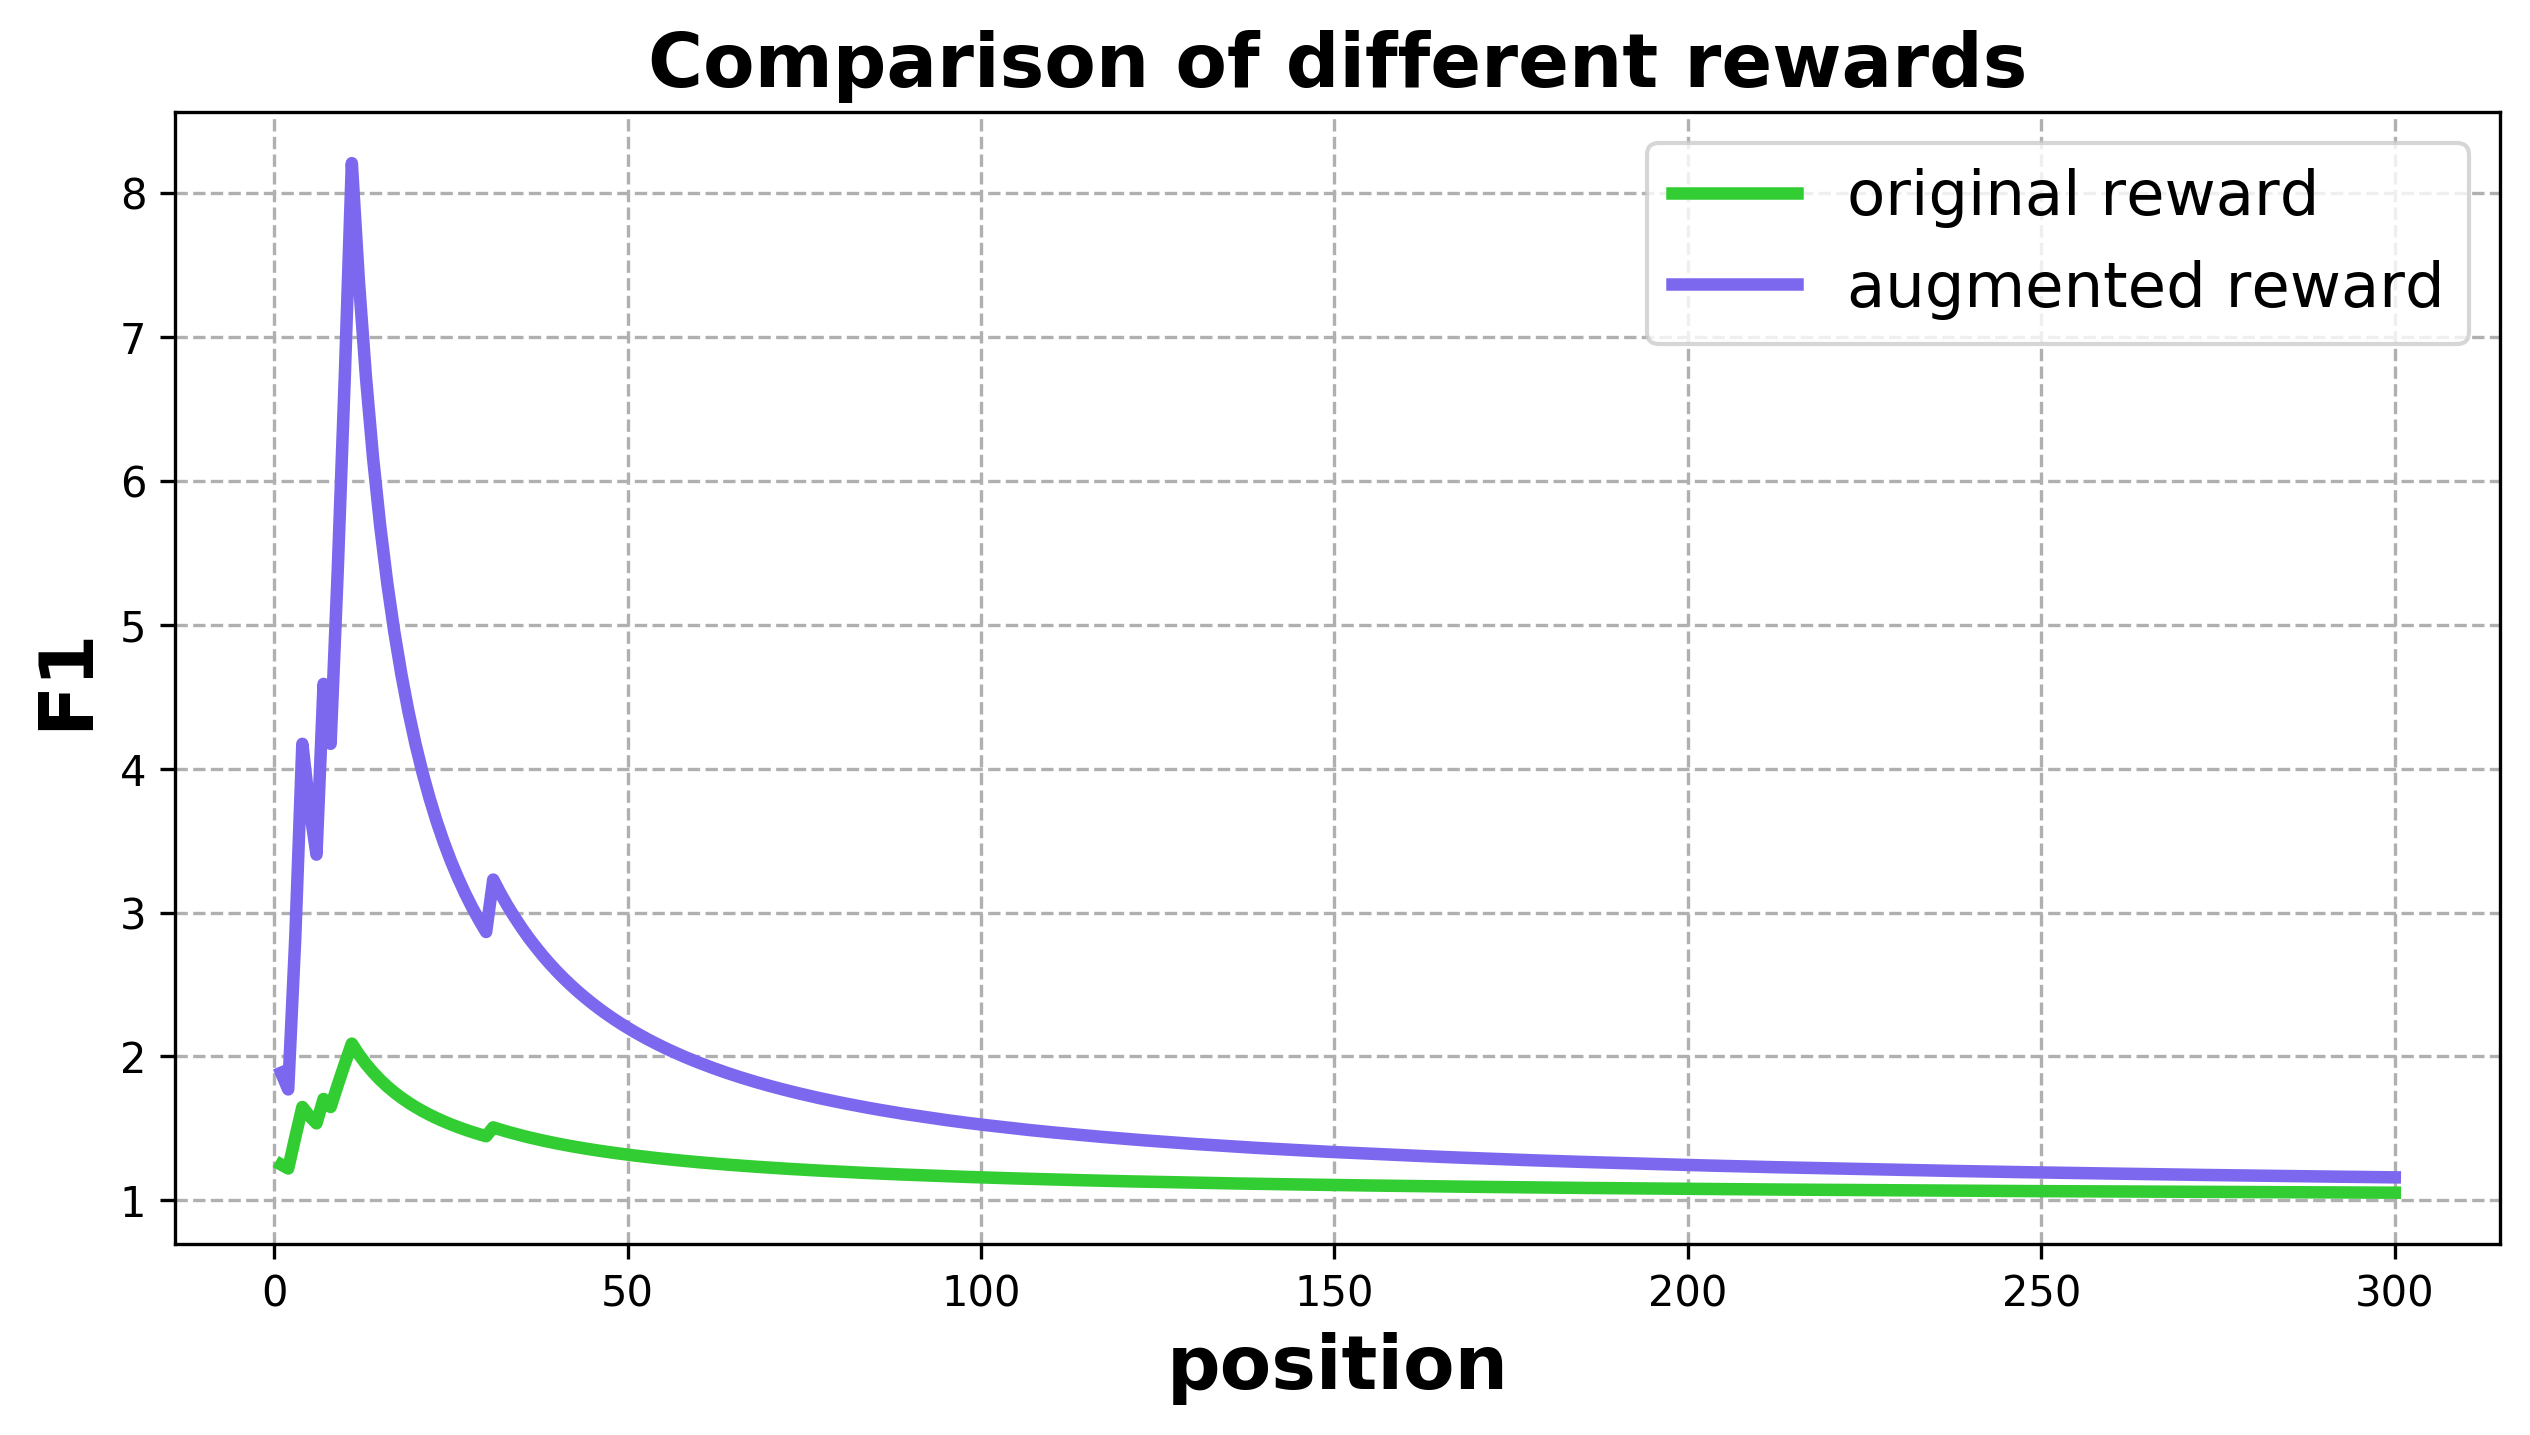

In [44]:
from matplotlib.ticker import FuncFormatter

x = list(range(1, 301))
plt.figure(figsize=(10,5), dpi=300)
plt.grid(linestyle = "--")

plt.plot(x,b, color="limegreen",linewidth=3.,label='original reward')
plt.plot(x,c, color="mediumslateblue",linewidth=3.,label='augmented reward')
plt.legend(fontsize=15)

plt.title('Comparison of different rewards', fontsize=18,fontweight='bold')
plt.xlabel('position', fontsize=18,fontweight='bold')
plt.ylabel('F1', fontsize=18,fontweight='bold')

In [19]:
random.randint(0,10)

7

In [20]:
import torch as t

In [58]:
a = t.tensor([0.2,0.24,0.56,0.35])

In [31]:
b = a.div(0.5).exp()
b

tensor([1.4918, 1.6161, 3.0649, 2.0138])

In [32]:
b.sum()

tensor(8.1865)

In [34]:
b.div(b.sum()).sum()

tensor(1.0000)

In [35]:
b.tolist()

[1.491824746131897, 1.6160744428634644, 3.064854145050049, 2.0137526988983154]

In [66]:
a = t.tensor([[1.,2.],[3.,4]])

In [68]:
t.sum(a, axis=1)

tensor([3., 7.])

In [76]:
b = t.cat((a,a,a), dim=0).div(2)

In [78]:
b[0] = 0

In [79]:
b

tensor([[0.0000, 0.0000],
        [1.5000, 2.0000],
        [0.5000, 1.0000],
        [1.5000, 2.0000],
        [0.5000, 1.0000],
        [1.5000, 2.0000]])